# **ArangoRDF**

<img src="https://github.com/ArangoDB-Community/ArangoRDF/blob/main/examples/assets/adb_logo.png?raw=1" alt="rdf" width="250"/>
<img src="https://github.com/ArangoDB-Community/ArangoRDF/blob/main/examples/assets/rdf_logo.png?raw=1" alt="rdf" width="200"/>

# Setup

In [ ]:
%%capture
!pip install adb-cloud-connector
!pip install git+https://github.com/ArangoDB-Community/ArangoRDF.git@arangordf-overhaul
!git clone -b "arangordf-overhaul" https://github.com/ArangoDB-Community/ArangoRDF.git 

In [ ]:
from adb_cloud_connector import get_temp_credentials
from arango import ArangoClient
import json

from rdflib import Graph, ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDFS, XSD

from arango_rdf import ArangoRDF

# Understanding RDF

RDF is a standard model for data interchange on the Web. RDF has features that facilitate data merging even if the underlying schemas differ, and it specifically supports the evolution of schemas over time without requiring all the data consumers to be changed.

RDF extends the linking structure of the Web to use URIs to name the relationship between things as well as the two ends of the link (this is usually referred to as a "triple"). Using this simple model, it allows structured and semi-structured data to be mixed, exposed, and shared across different applications.

This linking structure forms a directed, labeled graph, where the edges represent the named link between two resources, represented by the graph nodes. This graph view is the easiest possible mental model for RDF and is often used in easy-to-understand visual explanations.

Resources to get started:

* [RDF Primer](https://www.w3.org/TR/rdf11-concepts/)
* [RDFLib (Python)](https://pypi.org/project/rdflib/)
* [One Example for Modeling RDF as ArangoDB Graphs](https://www.arangodb.com/docs/stable/data-modeling-graphs-from-rdf.html)


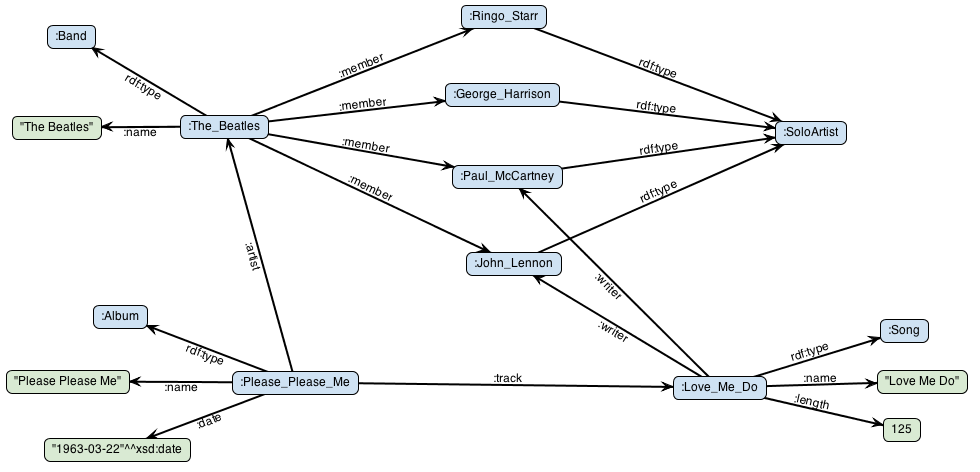

[RDFLib](https://github.com/RDFLib/rdflib) is a pure Python package for working with RDF. 

RDFLib aims to be a pythonic RDF API. RDFLib's main data object is a `Graph` which is a Python collection of RDF Subject, Predicate, Object Triples:

To create graph and load it with RDF data from DBPedia then print the results:

In [ ]:
g = Graph()
g.parse('http://dbpedia.org/resource/Semantic_Web')

for s, p, o in g:
    print(s, p, o)

The components of the triples are URIs (resources) or Literals (values).

URIs are grouped together by namespace, common namespaces are included in RDFLib:

In [ ]:
from rdflib.namespace import DC, DCTERMS, DOAP, FOAF, SKOS, OWL, RDF, RDFS, VOID, XMLNS, XSD

You can use them like this:



In [ ]:
g = Graph()
semweb = URIRef('http://dbpedia.org/resource/Semantic_Web')
val = g.value(semweb, RDFS.label)

Where `RDFS` is the RDFS namespace, `XSD` the XML Schema Datatypes namespace and `g.value` returns an object of the triple-pattern given (or an arbitrary one if multiple exist).

Or like this, adding a triple to a graph `g`:

In [ ]:
g.add((
    URIRef("http://example.com/person/nick"),
    FOAF.givenName,
    Literal("Nick", datatype=XSD.string)
))

The triple (in n-triples notation) `<http://example.com/person/nick> <http://xmlns.com/foaf/0.1/givenName> "Nick"^^<http://www.w3.org/2001/XMLSchema#string> .` is created where the property `FOAF.givenName` is the URI `<http://xmlns.com/foaf/0.1/givenName>` and `XSD.string` is the URI `<http://www.w3.org/2001/XMLSchema#string>`.

You can bind namespaces to prefixes to shorten the URIs for RDF/XML, Turtle, N3, TriG, TriX & JSON-LD serializations:

In [ ]:
g.bind("foaf", FOAF)
g.bind("xsd", XSD)

This will allow the n-triples triple above to be serialised like this:



In [ ]:
print(g.serialize(format="turtle"))

New Namespaces can also be defined:



In [ ]:
dbpedia = Namespace('http://dbpedia.org/ontology/')

abstracts = list(x for x in g.objects(semweb, dbpedia['abstract']) if x.language=='en')

# Create a Temporary ArangoDB Cloud Instance

In [ ]:
# Request temporary instance from the managed ArangoDB Cloud Service.
con = get_temp_credentials()
print(json.dumps(con, indent=2))

# Connect to the db via the python-arango driver
db = ArangoClient(hosts=con["url"]).db(con["dbName"], con["username"], con["password"], verify=True)

# Data Import

For demo purposes, we will be using the [ArangoDB Game Of Thrones Dataset](https://github.com/arangodb/example-datasets/tree/master/GameOfThrones).

In [ ]:
!chmod -R 755 ArangoRDF/
!./ArangoRDF/tests/tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --replication-factor 3  --input-directory "ArangoRDF/tests/data/adb/got_dump"

In [ ]:
if not db.has_graph("GameOfThrones"):
    db.create_graph(
        "GameOfThrones",
        edge_definitions=[
            {
                "edge_collection": "ChildOf",
                "from_vertex_collections": ["Characters"],
                "to_vertex_collections": ["Characters"],
            },
        ],
        orphan_collections=["Traits", "Locations"],
    )

# Instantiate ArangoRDF

Connect ArangoRDF to our temporary ArangoDB cluster:

In [ ]:
adbrdf = ArangoRDF(db)

# <u>RDF to ArangoDB</u>

#### RPT vs PGT

RDF-to-ArangoDB functionality has been implemented using concepts described in the paper [*Transforming RDF-star to Property Graphs: A Preliminary Analysis of Transformation Approaches*](https://arxiv.org/abs/2210.05781).

In other words, ArangoRDF offers 2 RDF-to-ArangoDB transformation methods:

1.   RDF-topology Preserving Transformation (RPT): `ArangoRDF.rdf_to_arangodb_by_rpt()`
2.   Property Graph Transformation (PGT): `ArangoRDF.rdf_to_arangodb_by_pgt()`

RPT preserves the RDF Graph structure by transforming each RDF Statement into an ArangoDB Edge.

PGT on the other hand ensures that Datatype Property Statements are mapped as ArangoDB Document Properties.

```ttl
@prefix ex: <http://example.org/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
ex:book ex:publish_date "1963-03-22"^^xsd:date .
ex:book ex:pages "100"^^xsd:integer .
ex:book ex:cover 20 .
ex:book ex:index 55 .
```

| RPT | PGT |
|:-------------------------:|:-------------------------:|
| ![image](https://user-images.githubusercontent.com/43019056/232347662-ab48ebfb-e215-4aff-af28-a5915414a8fd.png) | ![image](https://user-images.githubusercontent.com/43019056/232347681-c899ef09-53c7-44de-861e-6a98d448b473.png) |


#### Simple RPT & PGT Examples

In [ ]:
# Case 1: Standard RDF statement

data = """
@prefix ex: <http://example.com/> .

ex:alice a ex:Person .
ex:bob a ex:Person .
ex:alice ex:meets ex:bob .
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 2: The predicate of an RDF statement is subject in another statement
# Case 2.1: Predicate as subject and literal as object

data = """
@prefix ex: <http://example.com/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

ex:Sam ex:mentor ex:Lee .
ex:mentor rdfs:label "project supervisor" .
ex:mentor ex:name "mentor's name" .

ex:Sam a ex:Person .
ex:Lee a ex:Person .
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 2: The predicate of an RDF statement is subject in another statement
# Case 2.2: Predicate as subject and RDF resource as object

data = """
@prefix ex: <http://example.com/> .

ex:Martin ex:mentorJoe ex:Joe.
ex:mentorJoe ex:alias ex:teacher .
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 2: The predicate of an RDF statement is subject in another statement
# Case 2.3: Predicate as subject and RDF property as object - rdfs:subPropertyOf

data = """
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix ex: <http://example.com/> .

ex:Jan a ex:Person .
ex:Leo a ex:Person .
ex:Jan ex:supervise ex:Leo .

ex:supervise rdfs:subPropertyOf ex:administer .
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 2: The predicate of an RDF statement is subject in another statement
# Case 2.4: Predicate as subject and RDF class as object - rdf:type

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>.

ex:Tom ex:friend ex:Chris .
ex:friend rdf:type ex:relation .
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 3: Data types and language tags
# Case 3.1: Datatype property statements with different data types of the literal objects

data = """
@prefix ex: <http://example.com/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ex:book ex:publish_date "1963-03-22" .
ex:book ex:pages "100"^^xsd:integer .
ex:book ex:cover 20 .
ex:book ex:index "55" .
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 3: Data types and language tags
# Case 3.2: Datatype property statements with different language tags of the literal objects
# NOTE: PGT will currently discard the language tags!

data = """
@prefix ex: <http://example.com/> .

ex:book ex:title "Book"@en.
ex:book ex:title "Bog"@da.
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 4: RDF list

data = """
@prefix ex: <http://example.com/> .

ex:List1 ex:contents ("one" "two" "three").
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 5: Blank nodes

data = """
@prefix ex: <http://example.com/> .

ex:bob ex:nationality _:c .
_:c ex:country "Canada" .
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 6: Named graphs

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

ex:Monica ex:employer ex:ArangoDB .

ex:Graph1 {
    ex:Monica a ex:Entity .
    ex:Management a ex:Skill .
    ex:Monica ex:name "Monica" .
    ex:Monica ex:homepage <http://www.Monicahompage.org> .
    ex:Monica ex:hasSkill ex:Management .
}

ex:Graph2 {
    ex:Programming a ex:Skill .
    <http://www.Monicahompage.org> a ex:Website .
    ex:Monica a ex:Person .
    ex:Person rdfs:subClassOf ex:Entity .
    ex:Monica ex:hasSkill ex:Programming .
}
"""

cg = ConjunctiveGraph()
cg.parse(data=data, format='trig')

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", cg, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", cg, overwrite_graph=True)

In [ ]:
# Case 7: Multiple types for resources - rdf:type

data = """
@prefix : <http://example.com/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix adb: <http://www.arangodb.com/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .

:alice a :Arson .
:alice a :Author .

:Zenkey rdfs:subClassOf :Zebra .
:Zenkey rdfs:subClassOf :Donkey .
:Donkey rdfs:subClassOf :Animal . 
:Zebra rdfs:subClassOf :Animal .
:Human rdfs:subClassOf :Animal .
:Animal rdfs:subClassOf :LivingThing .
:LivingThing rdfs:subClassOf :Thing .
:Thing rdfs:subClassOf :Object .

:charlie a :LivingThing .
:charlie a :Animal .
:charlie a :Zenkey .

:marty a :LivingThing .
:marty a :Animal .
:marty a :Human .

:john a :Singer .
:john a :Writer .
:john a :Guitarist .
:john adb:collection "Artist" .
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

Cases 8 - 15: RDF-Star

`rdflib` has yet to introduce support for [Quoted Triples](https://www.w3.org/TR/rdf12-concepts/#dfn-quoted-triple), so ArangoRDF's support for RDF-star is based on [Triple Reification](https://www.w3.org/wiki/RdfReification).

In [ ]:
# Case 8:  Embedded object property statement in subject position

"""
@prefix ex: <http://example.com/> .
<< ex:alice ex:likes ex:bob >> ex:certainty 0.5 .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:alice;
    rdf:predicate ex:likes;
    rdf:object ex:bob ;
    ex:certainty 0.5 .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 9: Embedded datatype property statement in subject position
# Note: PGT does not support this case 

"""
@prefix ex: <http://example.com/> .
<< ex:Mark ex:age 28 >> ex:certainty 1 .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:Mark;
    rdf:predicate ex:age;
    rdf:object 28 ;
    ex:certainty 1 .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)

In [ ]:
# Case 10: Embedded object property statement in object position

"""
@prefix ex: <http://example.com/> .
ex:bobshomepage ex:source << ex:mainPage ex:writer ex:alice >> .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

_:x a rdf:Statement;
    rdf:subject ex:mainPage;
    rdf:predicate ex:writer;
    rdf:object ex:alice .

ex:bobshomepage ex:source _:x .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 11: Embedded object property statement in subject position and non-literal object
# Case 11.1: Asserted statement with non-literal object

"""
@prefix ex: <http://example.com/> .
<< ex:mainPage ex:writer ex:alice >> ex:source ex:bobshomepage .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:mainPage;
    rdf:predicate ex:writer;
    rdf:object ex:alice ;
    ex:source ex:bobshomepage .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 11: Embedded object property statement in subject position and non-literal object
# Case 11.2: Asserted statement with non-literal object that appears in another asserted statement

"""
@prefix ex: <http://example.com/> .
ex:alex ex:age 25 .
<< ex:alice ex:friend ex:bob >> ex:mentionedBy ex:alex .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

ex:alex ex:age 25 .

[] a rdf:Statement;
    rdf:subject ex:alice;
    rdf:predicate ex:friend;
    rdf:object ex:bob ;
    ex:mentionedBy ex:alex .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 12: Embedded statement in subject position - object property with rdf:type predicate
# Case 12.1: Asserted statement with rdf:type as predicate

"""
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

<< ex:mainPage ex:writer ex:alice >> rdf:type ex:bobshomepage .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:mainPage;
    rdf:predicate ex:writer;
    rdf:object ex:alice ;
    rdf:type ex:bobshomepage .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 12: Embedded statement in subject position - object property with rdf:type predicate
# Case 12.2: Embedded statement with rdf:type as predicate

"""
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

<< ex:lara rdf:type ex:writer >> ex:owner ex:journal .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

[] a rdf:Statement;
    rdf:subject ex:lara;
    rdf:predicate rdf:type;
    rdf:object ex:writer ;
    ex:owner ex:journal .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)


In [ ]:
# Case 13: Double nested RDF-star statement in subject position

"""
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

<< << ex:Steve ex:position ex:CEO >> ex:mentionedBy ex:book >> ex:source ex:Journal .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

_:x a rdf:Statement;
    rdf:subject ex:Steve;
    rdf:predicate ex:position;
    rdf:object ex:CEO .

[] a rdf:Statement;
    rdf:subject _:x;
    rdf:predicate ex:mentionedBy;
    rdf:object ex:book;
    ex:source ex:Journal .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 14: Multi-valued properties
# Case 14.1: RDF statements with same subject and predicate and different objects

data = """
@prefix ex: <http://example.com/> .

ex:college_page ex:subject "Info_Page";
    ex:subject "aau_page" .
"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)


In [ ]:
# Case 14: Multi-valued properties
# Case 14.2: RDF-star statements with the same subject and predicate and different objects

"""
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

<< ex:Mary ex:likes ex:Matt >> ex:certainty 0.5 .
<< ex:Mary ex:likes ex:Matt >> ex:certainty 1 .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt ;
    ex:certainty 0.5 .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt ;
    ex:certainty 1 .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

In [ ]:
# Case 15: Identical embedded RDF-star statements with different asserted statements

"""
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

<< ex:Mary ex:likes ex:Matt >> ex:certainty 0.5 .
<< ex:Mary ex:likes ex:Matt >> ex:source "text" .
"""

data = """
@prefix ex: <http://example.com/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt;
    ex:certainty 0.5 .

[] a rdf:Statement;
    rdf:subject ex:Mary;
    rdf:predicate ex:likes;
    rdf:object ex:Matt;
    ex:source "text" .

"""

g = Graph()
g.parse(data=data)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)

#### RDF to ArangoDB w/ Graph Contextualization

Contextualizing an RDF Graph within ArangoDB is a work-in-progress feature that attempts to enhance the Terminology Box of the original RDF Graph. This is done by:

1.   Loading the OWL, RDF, and RDFS Ontologies as 3 sub-graphs via `ArangoRDF.load_meta_ontology()`
2.   Setting the `contextualize_graph` flag to `True` in any of the `rdf_to_arangodb` methods.


Enabling the `contextualize_graph` flag currently provides the following features:

1.   Process RDF Predicates within the RDF Graph as their own ArangoDB Document, and cast a (predicate RDF.type RDF.Property) edge relationship into the ArangoDB graph for every RDF predicate used in the form (subject predicate object) within the RDF Graph.

2. Provide RDFS.Domain & RDFS.Range Inference on all RDF Resources within the RDF Graph, so long that no RDF.Type statement already exists in RDF Graph for the given resource.

3. Provide RDFS.Domain & RDFS.Range Introspection on all RDF Predicates within the RDF Graph, so long that no RDFS.Domain or RDFS.Range statement already exists for the given predicate.

In [ ]:
data = """
PREFIX : <http://stardog.com/tutorial/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

:The_Beatles      rdf:type  :Band .
:The_Beatles      :name     "The Beatles" .
:The_Beatles      :member   :John_Lennon .
:The_Beatles      :member   :Paul_McCartney .
:The_Beatles      :member   :Ringo_Starr .
:The_Beatles      :member   :George_Harrison .
:John_Lennon      rdf:type  :SoloArtist .
:Paul_McCartney   rdf:type  :SoloArtist .
:Ringo_Starr      rdf:type  :SoloArtist .
:George_Harrison  rdf:type  :SoloArtist .
:Please_Please_Me rdf:type  :Album .
:Please_Please_Me :name     "Please Please Me" .
:Please_Please_Me :date     "1963-03-22"^^xsd:date .
:Please_Please_Me :artist   :The_Beatles .
:Please_Please_Me :track    :Love_Me_Do .
:Love_Me_Do       rdf:type  :Song .
:Love_Me_Do       :name     "Love Me Do" .
:Love_Me_Do       :length   125 .
:Love_Me_Do       :writer   :John_Lennon .
:Love_Me_Do       :writer   :Paul_McCartney .

:McCartney        rdf:type  :Album .
:McCartney        :name     "McCartney" .
:McCartney        :date     "1970-04-17"^^xsd:date .
:McCartney        :artist   :Paul_McCartney .

:Imagine          rdf:type  :Album .
:Imagine          :name     "Imagine" .
:Imagine          :date     "1971-10-11"^^xsd:date .
:Imagine          :artist   :John_Lennon .
"""

g = Graph()
g.parse(data=data)

g = adbrdf.load_meta_ontology(g)

adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, contextualize_graph=True, overwrite_graph=True)
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, contextualize_graph=True, overwrite_graph=True)

# <u>ArangoDB to RDF</u>

The `arangodb_graph_to_rdf` and `arangodb_collections_to_rdf` methods return two objects:

1.   The RDF representation of the ArangoDB Graph, i.e `rdf_graph`
2.   Another RDF Graph mapping the RDF Resources to their designated ArangoDB Collection, i.e `adb_mapping`.

The second graph, `adb_mapping`, can be re-used in the RDF to ArangoDB (PGT) process to maintain the Document-to-Collection mappings.

#### Non-native

Non-native: An ArangoDB Graph that originates from an RDF Context, which has been brought over via one of the `rdf_to_arangodb` methods (RPT/PGT).

In [ ]:
data = """
PREFIX : <http://stardog.com/tutorial/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

:The_Beatles      rdf:type  :Band .
:The_Beatles      :name     "The Beatles" .
:The_Beatles      :member   :John_Lennon .
:The_Beatles      :member   :Paul_McCartney .
:The_Beatles      :member   :Ringo_Starr .
:The_Beatles      :member   :George_Harrison .
:John_Lennon      rdf:type  :SoloArtist .
:Paul_McCartney   rdf:type  :SoloArtist .
:Ringo_Starr      rdf:type  :SoloArtist .
:George_Harrison  rdf:type  :SoloArtist .
:Please_Please_Me rdf:type  :Album .
:Please_Please_Me :name     "Please Please Me" .
:Please_Please_Me :date     "1963-03-22"^^xsd:date .
:Please_Please_Me :artist   :The_Beatles .
:Please_Please_Me :track    :Love_Me_Do .
:Love_Me_Do       rdf:type  :Song .
:Love_Me_Do       :name     "Love Me Do" .
:Love_Me_Do       :length   125 .
:Love_Me_Do       :writer   :John_Lennon .
:Love_Me_Do       :writer   :Paul_McCartney .

:McCartney        rdf:type  :Album .
:McCartney        :name     "McCartney" .
:McCartney        :date     "1970-04-17"^^xsd:date .
:McCartney        :artist   :Paul_McCartney .

:Imagine          rdf:type  :Album .
:Imagine          :name     "Imagine" .
:Imagine          :date     "1971-10-11"^^xsd:date .
:Imagine          :artist   :John_Lennon .
"""

g = Graph()
g.parse(data=data)

# Selecting RPT or PGT for this example does not matter, as the
# end-result is the same.
adbrdf.rdf_to_arangodb_by_pgt("DataPGT", g, overwrite_graph=True)
# adbrdf.rdf_to_arangodb_by_rpt("DataRPT", g, overwrite_graph=True)

# ArangoDB to RDF via Graph Name
g2, adb_mapping_2 = adbrdf.arangodb_graph_to_rdf("DataPGT", Graph())

# ArangoDB to RDF via Collection Names
g3, adb_mapping_3 = adbrdf.arangodb_collections_to_rdf(
    "DataPGT",
    Graph(),
    v_cols={"Album", "Band", "Class", "Property", "SoloArtist", "Song"},
    e_cols={"artist", "member", "track", "type", "writer"},
)

print(len(g2), len(adb_mapping_2))
print(len(g3), len(adb_mapping_3))

print('--------------------')
print(g2.serialize())
print('--------------------')
print(adb_mapping_2.serialize())
print('--------------------')

#### Native

Native: ArangoDB Graphs that originate from an ArangoDB context. We'll be using the [ArangoDB Game Of Thrones Dataset](https://github.com/arangodb/example-datasets/tree/master/GameOfThrones).

Since we are dealing with a "native" ArangoDB Graph, we can rely on the `infer_type_from_adb_col` flag to indicate that `rdf:type` statements of the form (adb_doc rdf:type adb_col) should be inferred upon transferring ArangoDB Documents into RDF.

We can also take advantage of the `include_adb_key_statements` flag to indicate that `adb:key` statements of the form (adb_doc adb:key adb_doc["key"]) should be generated upon transferring ArangoDB Documents into RDF.

Note that enabling `infer_type_from_adb_col` `include_adb_key_statements` is only recommended if your ArangoDB graph is "native" to ArangoDB. That is, the ArangoDB graph does not originate from an RDF context.

Finally, we set the `list_conversion_mode` flag to `collection` to indicate that JSON Lists within ArangoDB Documents should be converted into RDF Collections (other options include `container`, and `static`). 

In [ ]:
rdf_graph, adb_mapping = adbrdf.arangodb_graph_to_rdf("GameOfThrones", rdf_graph=Graph(), list_conversion_mode="collection", infer_type_from_adb_v_col=True, include_adb_key_statements=True)
print(rdf_graph.serialize())